In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pickle



In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:

transform = transforms.Compose([
    transforms.Resize((28, 28)), 
    transforms.Grayscale(num_output_channels=1),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])



train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [6]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(128 * 3 * 3, 128) 
        self.fc2 = nn.Linear(128, 10) 

        self.feature_extractor = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            self.conv2,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            self.conv3,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            self.fc1
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)  
        output = self.fc2(features)  
        return output, features 


In [ ]:
model = CustomCNN().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs, _ = model(images)  
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

train_model(num_epochs=10)


In [3]:
torch.save(model , "feature_extractor.pt")

In [8]:
def extract_features(dataloader):
    model.eval()  
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.cuda()  
            labels_list.append(labels)

            _, features = model(images) 

            features_list.append(features.cpu())  

    return torch.cat(features_list), torch.cat(labels_list)

model = torch.load("models/feature_extractor.pt" , weights_only=False).to(device)

train_features, train_labels = extract_features(train_loader)
test_features, test_labels = extract_features(test_loader)

print(f"Train Features Shape: {train_features.shape}")
print(f"Test Features Shape: {test_features.shape}")


100%|██████████| 157/157 [00:03<00:00, 39.62it/s]

Train Features Shape: torch.Size([60000, 128])
Test Features Shape: torch.Size([10000, 128])


In [17]:
torch.save(train_features , "data/train_features.pt")
torch.save(test_features , "data/test_features.pt")
torch.save(train_labels , "data/train_labels.pt")
torch.save(test_labels , "data/test_labels.pt")


In [9]:
dic = {
    0 : (-1,-1,-1,-1),
    1 : (-1,-1,-1,1),
    2 : (-1,-1,1,-1),
    3 : (-1,-1,1,1),
    4 : (-1,1,-1,-1),
    5 : (-1,1,-1,1),
    6 : (-1,1,1,-1),
    7 : (-1,1,1,1),
    8 : (1,-1,-1,-1),
    9 : (1,-1,-1,1),
}

train_buckets = [dic[i.item()] for i in train_labels]
test_buckets = [dic[i.item()] for i in test_labels]

In [10]:
def create_dic(binary_hash_buckets):

    dic = {}

    for i , hash in enumerate(binary_hash_buckets):
        if hash in dic.keys():
            dic[hash].append(train_features[i].numpy())
            continue
        dic[hash] = [train_features[i].numpy()]
    
    return dic

In [11]:
def average_similarity_all_keys(dictionary):
    avg_similarity_scores = 0

    for hash_key, vectors in dictionary.items():
        vectors = np.array(vectors)  
        if len(vectors) < 2:
            continue

        similarity_matrix = cosine_similarity(vectors)

        triu_indices = np.triu_indices(len(vectors), k=1)
        similarity_scores = similarity_matrix[triu_indices]

        avg_similarity_scores += np.mean(similarity_scores) if similarity_scores.size > 0 else None

    return avg_similarity_scores/len(dictionary)




In [12]:
train_dic = create_dic(train_buckets)

average_similarity_all_keys(train_dic)

0.8542236030101776

In [16]:
with open("data/train_dic.pkl" , "wb") as f:
    pickle.dump(train_dic , f)


In [13]:
class HashingMLP(nn.Module):
    def __init__(self, input_dim=128, output_dim=4):
        super(HashingMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, output_dim), 
            nn.Tanh()  
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
hashing_mlp = HashingMLP().to(device)
optimizer = optim.Adam(hashing_mlp.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.TripletMarginLoss(margin=1.0, p=2)

train_features_tensor = torch.tensor(train_features, dtype=torch.float32).to(device)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(device)

batch_size = 32
num_samples = len(train_features_tensor)

num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    indices = torch.randperm(num_samples)  
    
    for i in tqdm(range(0, num_samples - batch_size, batch_size)):
        batch_indices = indices[i : i + batch_size]
        
        anchor = train_features_tensor[batch_indices]
        anchor_hash = hashing_mlp(anchor)

        positive_indices = [
            random.choice(torch.where(train_labels_tensor == train_labels_tensor[idx])[0]).item()
            for idx in batch_indices
        ]
        positive = train_features_tensor[positive_indices]
        positive_hash = hashing_mlp(positive)

        negative_indices = [
            random.choice(torch.where(train_labels_tensor != train_labels_tensor[idx])[0]).item()
            for idx in batch_indices
        ]
        negative = train_features_tensor[negative_indices]
        negative_hash = hashing_mlp(negative)

        optimizer.zero_grad()
        loss = criterion(anchor_hash, positive_hash, negative_hash)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()  
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / (num_samples // batch_size):.4f}")

Epoch 1/100: 100%|██████████| 235/235 [00:53<00:00,  4.41it/s, loss=0.0000]


Epoch [1/100], Loss: 0.0597, LR: 0.001000


Epoch 2/100: 100%|██████████| 235/235 [00:54<00:00,  4.35it/s, loss=0.0000]


Epoch [2/100], Loss: 0.0018, LR: 0.001000


Epoch 3/100: 100%|██████████| 235/235 [00:54<00:00,  4.34it/s, loss=0.0000]


Epoch [3/100], Loss: 0.0013, LR: 0.001000


Epoch 4/100: 100%|██████████| 235/235 [00:54<00:00,  4.31it/s, loss=0.0009]


Epoch [4/100], Loss: 0.0011, LR: 0.001000


Epoch 5/100: 100%|██████████| 235/235 [00:52<00:00,  4.49it/s, loss=0.0013]


Epoch [5/100], Loss: 0.0010, LR: 0.000500


Epoch 6/100: 100%|██████████| 235/235 [00:52<00:00,  4.50it/s, loss=0.0000]


Epoch [6/100], Loss: 0.0006, LR: 0.000500


Epoch 7/100: 100%|██████████| 235/235 [00:50<00:00,  4.68it/s, loss=0.0000]


Epoch [7/100], Loss: 0.0007, LR: 0.000500


Epoch 8/100: 100%|██████████| 235/235 [00:50<00:00,  4.62it/s, loss=0.0000]


Epoch [8/100], Loss: 0.0007, LR: 0.000500


Epoch 9/100: 100%|██████████| 235/235 [00:50<00:00,  4.68it/s, loss=0.0000]


Epoch [9/100], Loss: 0.0007, LR: 0.000500


Epoch 10/100: 100%|██████████| 235/235 [00:50<00:00,  4.64it/s, loss=0.0000]


Epoch [10/100], Loss: 0.0007, LR: 0.000250


Epoch 11/100: 100%|██████████| 235/235 [00:50<00:00,  4.67it/s, loss=0.0000]


Epoch [11/100], Loss: 0.0005, LR: 0.000250


Epoch 12/100: 100%|██████████| 235/235 [00:50<00:00,  4.70it/s, loss=0.0000]


Epoch [12/100], Loss: 0.0005, LR: 0.000250


Epoch 13/100: 100%|██████████| 235/235 [00:50<00:00,  4.63it/s, loss=0.0000]


Epoch [13/100], Loss: 0.0004, LR: 0.000250


Epoch 14/100: 100%|██████████| 235/235 [00:52<00:00,  4.45it/s, loss=0.0000]


Epoch [14/100], Loss: 0.0004, LR: 0.000250


Epoch 15/100: 100%|██████████| 235/235 [00:52<00:00,  4.46it/s, loss=0.0000]


Epoch [15/100], Loss: 0.0004, LR: 0.000125


Epoch 16/100: 100%|██████████| 235/235 [00:52<00:00,  4.45it/s, loss=0.0000]


Epoch [16/100], Loss: 0.0004, LR: 0.000125


Epoch 17/100: 100%|██████████| 235/235 [00:52<00:00,  4.47it/s, loss=0.0002]


Epoch [17/100], Loss: 0.0005, LR: 0.000125


Epoch 18/100: 100%|██████████| 235/235 [00:52<00:00,  4.47it/s, loss=0.0000]


Epoch [18/100], Loss: 0.0003, LR: 0.000125


Epoch 19/100: 100%|██████████| 235/235 [00:54<00:00,  4.29it/s, loss=0.0000]


Epoch [19/100], Loss: 0.0003, LR: 0.000125


Epoch 20/100: 100%|██████████| 235/235 [00:50<00:00,  4.69it/s, loss=0.0000]


Epoch [20/100], Loss: 0.0003, LR: 0.000063


Epoch 21/100: 100%|██████████| 235/235 [00:50<00:00,  4.67it/s, loss=0.0000]


Epoch [21/100], Loss: 0.0003, LR: 0.000063


Epoch 22/100: 100%|██████████| 235/235 [00:49<00:00,  4.72it/s, loss=0.0000]


Epoch [22/100], Loss: 0.0002, LR: 0.000063


Epoch 23/100: 100%|██████████| 235/235 [00:49<00:00,  4.71it/s, loss=0.0000]


Epoch [23/100], Loss: 0.0002, LR: 0.000063


Epoch 24/100: 100%|██████████| 235/235 [00:50<00:00,  4.68it/s, loss=0.0000]


Epoch [24/100], Loss: 0.0002, LR: 0.000063


Epoch 25/100: 100%|██████████| 235/235 [00:50<00:00,  4.64it/s, loss=0.0000]


Epoch [25/100], Loss: 0.0003, LR: 0.000031


Epoch 26/100: 100%|██████████| 235/235 [00:50<00:00,  4.65it/s, loss=0.0000]


Epoch [26/100], Loss: 0.0003, LR: 0.000031


Epoch 27/100: 100%|██████████| 235/235 [00:51<00:00,  4.57it/s, loss=0.0000]


Epoch [27/100], Loss: 0.0002, LR: 0.000031


Epoch 28/100: 100%|██████████| 235/235 [00:50<00:00,  4.63it/s, loss=0.0000]


Epoch [28/100], Loss: 0.0003, LR: 0.000031


Epoch 29/100: 100%|██████████| 235/235 [00:51<00:00,  4.58it/s, loss=0.0008]


Epoch [29/100], Loss: 0.0002, LR: 0.000031


Epoch 30/100: 100%|██████████| 235/235 [00:50<00:00,  4.64it/s, loss=0.0000]


Epoch [30/100], Loss: 0.0003, LR: 0.000016


Epoch 31/100: 100%|██████████| 235/235 [00:50<00:00,  4.66it/s, loss=0.0000]


Epoch [31/100], Loss: 0.0003, LR: 0.000016


Epoch 32/100: 100%|██████████| 235/235 [00:50<00:00,  4.65it/s, loss=0.0000]


Epoch [32/100], Loss: 0.0003, LR: 0.000016


Epoch 33/100: 100%|██████████| 235/235 [00:50<00:00,  4.66it/s, loss=0.0000]


Epoch [33/100], Loss: 0.0003, LR: 0.000016


Epoch 34/100: 100%|██████████| 235/235 [00:50<00:00,  4.64it/s, loss=0.0000]


Epoch [34/100], Loss: 0.0003, LR: 0.000016


Epoch 35/100: 100%|██████████| 235/235 [00:52<00:00,  4.45it/s, loss=0.0000]


Epoch [35/100], Loss: 0.0001, LR: 0.000008


Epoch 36/100: 100%|██████████| 235/235 [00:54<00:00,  4.35it/s, loss=0.0000]


Epoch [36/100], Loss: 0.0002, LR: 0.000008


Epoch 37/100: 100%|██████████| 235/235 [00:53<00:00,  4.41it/s, loss=0.0000]


Epoch [37/100], Loss: 0.0003, LR: 0.000008


Epoch 38/100: 100%|██████████| 235/235 [00:52<00:00,  4.51it/s, loss=0.0000]


Epoch [38/100], Loss: 0.0002, LR: 0.000008


Epoch 39/100: 100%|██████████| 235/235 [00:50<00:00,  4.63it/s, loss=0.0000]


Epoch [39/100], Loss: 0.0002, LR: 0.000008


Epoch 40/100: 100%|██████████| 235/235 [00:49<00:00,  4.71it/s, loss=0.0000]


Epoch [40/100], Loss: 0.0002, LR: 0.000004


Epoch 41/100: 100%|██████████| 235/235 [00:48<00:00,  4.85it/s, loss=0.0000]


Epoch [41/100], Loss: 0.0002, LR: 0.000004


Epoch 42/100: 100%|██████████| 235/235 [00:48<00:00,  4.90it/s, loss=0.0000]


Epoch [42/100], Loss: 0.0002, LR: 0.000004


Epoch 43/100: 100%|██████████| 235/235 [00:45<00:00,  5.14it/s, loss=0.0000]


Epoch [43/100], Loss: 0.0002, LR: 0.000004


Epoch 44/100: 100%|██████████| 235/235 [00:49<00:00,  4.78it/s, loss=0.0000]


Epoch [44/100], Loss: 0.0003, LR: 0.000004


Epoch 45/100: 100%|██████████| 235/235 [00:48<00:00,  4.89it/s, loss=0.0000]


Epoch [45/100], Loss: 0.0002, LR: 0.000002


Epoch 46/100: 100%|██████████| 235/235 [00:47<00:00,  4.90it/s, loss=0.0000]


Epoch [46/100], Loss: 0.0002, LR: 0.000002


Epoch 47/100: 100%|██████████| 235/235 [00:47<00:00,  4.96it/s, loss=0.0000]


Epoch [47/100], Loss: 0.0001, LR: 0.000002


Epoch 48/100: 100%|██████████| 235/235 [00:48<00:00,  4.84it/s, loss=0.0000]


Epoch [48/100], Loss: 0.0003, LR: 0.000002


Epoch 49/100: 100%|██████████| 235/235 [00:49<00:00,  4.79it/s, loss=0.0000]


Epoch [49/100], Loss: 0.0002, LR: 0.000002


Epoch 50/100: 100%|██████████| 235/235 [00:47<00:00,  4.95it/s, loss=0.0000]


Epoch [50/100], Loss: 0.0002, LR: 0.000001


Epoch 51/100: 100%|██████████| 235/235 [00:48<00:00,  4.89it/s, loss=0.0000]


Epoch [51/100], Loss: 0.0002, LR: 0.000001


Epoch 52/100: 100%|██████████| 235/235 [00:46<00:00,  5.07it/s, loss=0.0005]


Epoch [52/100], Loss: 0.0003, LR: 0.000001


Epoch 53/100: 100%|██████████| 235/235 [00:47<00:00,  4.92it/s, loss=0.0000]


Epoch [53/100], Loss: 0.0002, LR: 0.000001


Epoch 54/100: 100%|██████████| 235/235 [00:47<00:00,  4.99it/s, loss=0.0000]


Epoch [54/100], Loss: 0.0003, LR: 0.000001


Epoch 55/100: 100%|██████████| 235/235 [00:47<00:00,  4.99it/s, loss=0.0000]


Epoch [55/100], Loss: 0.0002, LR: 0.000000


Epoch 56/100: 100%|██████████| 235/235 [00:46<00:00,  5.01it/s, loss=0.0000]


Epoch [56/100], Loss: 0.0002, LR: 0.000000


Epoch 57/100: 100%|██████████| 235/235 [00:46<00:00,  5.05it/s, loss=0.0000]


Epoch [57/100], Loss: 0.0002, LR: 0.000000


Epoch 58/100: 100%|██████████| 235/235 [00:46<00:00,  5.06it/s, loss=0.0000]


Epoch [58/100], Loss: 0.0002, LR: 0.000000


Epoch 59/100: 100%|██████████| 235/235 [00:47<00:00,  4.99it/s, loss=0.0000]


Epoch [59/100], Loss: 0.0002, LR: 0.000000


Epoch 60/100: 100%|██████████| 235/235 [00:45<00:00,  5.14it/s, loss=0.0000]


Epoch [60/100], Loss: 0.0002, LR: 0.000000


Epoch 61/100: 100%|██████████| 235/235 [00:46<00:00,  5.05it/s, loss=0.0000]


Epoch [61/100], Loss: 0.0003, LR: 0.000000


Epoch 62/100: 100%|██████████| 235/235 [00:46<00:00,  5.05it/s, loss=0.0000]


Epoch [62/100], Loss: 0.0002, LR: 0.000000


Epoch 63/100: 100%|██████████| 235/235 [00:45<00:00,  5.14it/s, loss=0.0000]


Epoch [63/100], Loss: 0.0001, LR: 0.000000


Epoch 64/100: 100%|██████████| 235/235 [00:49<00:00,  4.79it/s, loss=0.0000]


Epoch [64/100], Loss: 0.0002, LR: 0.000000


Epoch 65/100: 100%|██████████| 235/235 [00:48<00:00,  4.80it/s, loss=0.0000]


Epoch [65/100], Loss: 0.0002, LR: 0.000000


Epoch 66/100: 100%|██████████| 235/235 [00:48<00:00,  4.89it/s, loss=0.0000]


Epoch [66/100], Loss: 0.0001, LR: 0.000000


Epoch 67/100: 100%|██████████| 235/235 [00:47<00:00,  4.95it/s, loss=0.0000]


Epoch [67/100], Loss: 0.0002, LR: 0.000000


Epoch 68/100: 100%|██████████| 235/235 [00:46<00:00,  5.00it/s, loss=0.0000]


Epoch [68/100], Loss: 0.0002, LR: 0.000000


Epoch 69/100: 100%|██████████| 235/235 [00:49<00:00,  4.74it/s, loss=0.0000]


Epoch [69/100], Loss: 0.0002, LR: 0.000000


Epoch 70/100: 100%|██████████| 235/235 [00:46<00:00,  5.08it/s, loss=0.0000]


Epoch [70/100], Loss: 0.0002, LR: 0.000000


Epoch 71/100: 100%|██████████| 235/235 [00:46<00:00,  5.09it/s, loss=0.0000]


Epoch [71/100], Loss: 0.0002, LR: 0.000000


Epoch 72/100: 100%|██████████| 235/235 [00:45<00:00,  5.16it/s, loss=0.0000]


Epoch [72/100], Loss: 0.0002, LR: 0.000000


Epoch 73/100: 100%|██████████| 235/235 [00:45<00:00,  5.17it/s, loss=0.0000]


Epoch [73/100], Loss: 0.0002, LR: 0.000000


Epoch 74/100: 100%|██████████| 235/235 [00:45<00:00,  5.13it/s, loss=0.0000]


Epoch [74/100], Loss: 0.0002, LR: 0.000000


Epoch 75/100: 100%|██████████| 235/235 [00:45<00:00,  5.16it/s, loss=0.0000]


Epoch [75/100], Loss: 0.0002, LR: 0.000000


Epoch 76/100: 100%|██████████| 235/235 [00:45<00:00,  5.21it/s, loss=0.0000]


Epoch [76/100], Loss: 0.0002, LR: 0.000000


Epoch 77/100: 100%|██████████| 235/235 [00:45<00:00,  5.19it/s, loss=0.0000]


Epoch [77/100], Loss: 0.0002, LR: 0.000000


Epoch 78/100: 100%|██████████| 235/235 [00:45<00:00,  5.18it/s, loss=0.0000]


Epoch [78/100], Loss: 0.0002, LR: 0.000000


Epoch 79/100: 100%|██████████| 235/235 [00:45<00:00,  5.18it/s, loss=0.0000]


Epoch [79/100], Loss: 0.0002, LR: 0.000000


Epoch 80/100: 100%|██████████| 235/235 [00:45<00:00,  5.15it/s, loss=0.0089]


Epoch [80/100], Loss: 0.0002, LR: 0.000000


Epoch 81/100: 100%|██████████| 235/235 [00:46<00:00,  5.08it/s, loss=0.0000]


Epoch [81/100], Loss: 0.0002, LR: 0.000000


Epoch 82/100: 100%|██████████| 235/235 [00:45<00:00,  5.11it/s, loss=0.0000]


Epoch [82/100], Loss: 0.0002, LR: 0.000000


Epoch 83/100: 100%|██████████| 235/235 [00:45<00:00,  5.15it/s, loss=0.0024]


Epoch [83/100], Loss: 0.0001, LR: 0.000000


Epoch 84/100: 100%|██████████| 235/235 [00:45<00:00,  5.12it/s, loss=0.0000]


Epoch [84/100], Loss: 0.0003, LR: 0.000000


Epoch 85/100: 100%|██████████| 235/235 [00:46<00:00,  5.05it/s, loss=0.0000]


Epoch [85/100], Loss: 0.0002, LR: 0.000000


Epoch 86/100: 100%|██████████| 235/235 [00:45<00:00,  5.13it/s, loss=0.0000]


Epoch [86/100], Loss: 0.0001, LR: 0.000000


Epoch 87/100: 100%|██████████| 235/235 [00:46<00:00,  5.08it/s, loss=0.0000]


Epoch [87/100], Loss: 0.0002, LR: 0.000000


Epoch 88/100: 100%|██████████| 235/235 [00:46<00:00,  5.08it/s, loss=0.0000]


Epoch [88/100], Loss: 0.0003, LR: 0.000000


Epoch 89/100: 100%|██████████| 235/235 [00:45<00:00,  5.16it/s, loss=0.0000]


Epoch [89/100], Loss: 0.0002, LR: 0.000000


Epoch 90/100: 100%|██████████| 235/235 [00:46<00:00,  5.07it/s, loss=0.0000]


Epoch [90/100], Loss: 0.0002, LR: 0.000000


Epoch 91/100: 100%|██████████| 235/235 [00:45<00:00,  5.11it/s, loss=0.0000]


Epoch [91/100], Loss: 0.0002, LR: 0.000000


Epoch 92/100: 100%|██████████| 235/235 [00:46<00:00,  5.04it/s, loss=0.0000]


Epoch [92/100], Loss: 0.0002, LR: 0.000000


Epoch 93/100: 100%|██████████| 235/235 [00:46<00:00,  5.05it/s, loss=0.0000]


Epoch [93/100], Loss: 0.0003, LR: 0.000000


Epoch 94/100: 100%|██████████| 235/235 [00:46<00:00,  5.06it/s, loss=0.0000]


Epoch [94/100], Loss: 0.0002, LR: 0.000000


Epoch 95/100: 100%|██████████| 235/235 [00:45<00:00,  5.12it/s, loss=0.0000]


Epoch [95/100], Loss: 0.0003, LR: 0.000000


Epoch 96/100: 100%|██████████| 235/235 [00:45<00:00,  5.18it/s, loss=0.0000]


Epoch [96/100], Loss: 0.0003, LR: 0.000000


Epoch 97/100: 100%|██████████| 235/235 [00:45<00:00,  5.16it/s, loss=0.0029]


Epoch [97/100], Loss: 0.0003, LR: 0.000000


Epoch 98/100: 100%|██████████| 235/235 [00:46<00:00,  5.10it/s, loss=0.0000]


Epoch [98/100], Loss: 0.0002, LR: 0.000000


Epoch 99/100: 100%|██████████| 235/235 [00:46<00:00,  5.07it/s, loss=0.0000]


Epoch [99/100], Loss: 0.0002, LR: 0.000000


Epoch 100/100: 100%|██████████| 235/235 [00:46<00:00,  5.08it/s, loss=0.0059]

Epoch [100/100], Loss: 0.0003, LR: 0.000000


In [297]:
history

{'epoch_losses': [0.059743355792213945,
  0.001841343566775322,
  0.0012515975182202268,
  0.0010647164350573687,
  0.0010491942550907743,
  0.0006173630512537475,
  0.0006675085558139897,
  0.0006727378320028173,
  0.0006919452127941111,
  0.000706749613535531,
  0.0005317514068744284,
  0.0005062997697832737,
  0.0004144399070200768,
  0.00035111366751346183,
  0.000391961040688639,
  0.0003865774849707142,
  0.00046766005119586244,
  0.0002928445412916072,
  0.00027573733055528173,
  0.00028780416308089776,
  0.00029662472413892444,
  0.00023448257707059383,
  0.0002455790844210919,
  0.00017899044175097282,
  0.000269146872922144,
  0.00027809774582373333,
  0.0002362901592587537,
  0.000279589879148184,
  0.00018181345955607423,
  0.0003410142668067141,
  0.00026294497000251677,
  0.0002858445494178128,
  0.0002639047266479502,
  0.0002949831442550776,
  0.00014968264174271137,
  0.0002037437969541296,
  0.00026970267929929366,
  0.00022511157266637112,
  0.0002425141493849298,
  

In [295]:
torch.save(hashing_mlp , "improved_hash_100.pt")

In [14]:
import matplotlib.pyplot as plt

In [15]:
mlp = torch.load("models/improved_hash.pt")

C:\Users\amodj\AppData\Local\Temp\ipykernel_36032\3741935403.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp = torch.load("models/improved_hash.pt")


In [16]:
import faiss
import numpy as np
import pickle


faiss_indices = {index : faiss.IndexFlatL2(train_features.shape[1]) for index in dic.values()}

for index in faiss_indices.keys():
    faiss_indices[index].add(np.array(train_dic[index]))

with open("database/faiss.pkl" , "wb") as f:
    pickle.dump(faiss_indices , f)




In [303]:
pred = []

with torch.no_grad():
    for feature in tqdm(train_features):
        indices = tuple(torch.sign(mlp(feature.to(device))).cpu().numpy().tolist())
        pred.append(indices)

100%|██████████| 60000/60000 [00:48<00:00, 1248.62it/s]


In [113]:
all_zeros = train_dic[(-1,-1,-1,-1)]

100%|██████████| 5923/5923 [00:05<00:00, 991.38it/s] 


In [301]:
set(pred)


{(-1.0, -1.0, -1.0, -1.0),
 (-1.0, -1.0, -1.0, 1.0),
 (-1.0, -1.0, 1.0, -1.0),
 (-1.0, -1.0, 1.0, 1.0),
 (-1.0, 1.0, -1.0, -1.0),
 (-1.0, 1.0, -1.0, 1.0),
 (-1.0, 1.0, 1.0, -1.0),
 (-1.0, 1.0, 1.0, 1.0),
 (1.0, -1.0, -1.0, -1.0),
 (1.0, -1.0, -1.0, 1.0),
 (1.0, -1.0, 1.0, -1.0),
 (1.0, 1.0, -1.0, -1.0),
 (1.0, 1.0, -1.0, 1.0),
 (1.0, 1.0, 1.0, 1.0)}

In [309]:
pred = []

with torch.no_grad():
    for feature in tqdm(train_features):
        indices = tuple(torch.sign(mlp(feature.to(device))).cpu().numpy().tolist())
        pred.append(indices)

correct = 0
incorrect = 0

for x , y in zip(train_buckets , pred):
    if x == y:
        correct += 1
    else:
        incorrect += 1

print(f"Correct : {correct} | Incorrect : {incorrect} | Accuracy : {correct / 60000}")

Correct : 59856 | Incorrect : 144 | Accuracy : 0.9976


In [304]:
pred_dic = {i : [] for i in list(set(pred))}

for i in range(len(pred)):
    pred_dic[pred[i]].append(train_features[i].cpu())

In [ ]:
import numpy as np
from typing import Dict, List, Generator
from collections import defaultdict

def batch_generator(data: np.ndarray, labels: np.ndarray, batch_size: int) -> Generator:
    num_samples = len(data)
    indices = np.arange(num_samples)
    
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_indices = indices[start_idx:end_idx]
        yield data[batch_indices], labels[batch_indices], batch_indices

import numpy as np

def batch_simhash(feature_vectors: np.ndarray, hash_bits: int = 16, seed: int = 42) -> np.ndarray:
    batch_size, feature_dim = feature_vectors.shape

    norms = np.linalg.norm(feature_vectors, axis=1, keepdims=True)
    feature_vectors = feature_vectors / (norms + 1e-10)  

    np.random.seed(seed)

    random_matrix = np.random.randn(feature_dim, hash_bits)
    random_matrix, _ = np.linalg.qr(random_matrix)  

    projections = np.dot(feature_vectors, random_matrix)

    binary_hashes = (projections > np.median(projections, axis=0)).astype(np.uint64)

    simhashes = np.zeros(batch_size, dtype=np.uint64)
    for i in range(hash_bits):
        simhashes |= binary_hashes[:, i] << i  

    return simhashes


def cluster_similar_images_batch(
    feature_vectors: np.ndarray, 
    labels: np.ndarray, 
    batch_size: int = 1000,
    hash_bits: int = 16,
) -> Dict[int, List[tuple]]:
 
    clusters = defaultdict(list)
    total_processed = 0
    
    for batch_data, batch_labels, batch_indices in batch_generator(feature_vectors, labels, batch_size):
        batch_hashes = batch_simhash(batch_data , hash_bits)
        
        for i, hash_value in enumerate(batch_hashes):
            clusters[int(hash_value)].append(batch_data[i])
        
        total_processed += len(batch_data)
    
    return clusters



n_samples = 10000
feature_dim = 128
np.random.seed(42)

feature_vectors = train_features.cpu()
labels = train_labels.cpu()

hash_sizes = [i for i in range(4,33)]

hash_dic =  {}

for hash_size in tqdm(hash_sizes):
    clusters = cluster_similar_images_batch(
        feature_vectors=feature_vectors,
        labels=labels,
        batch_size=512,
        hash_bits = hash_size
    )

    hash_dic[hash_size] = average_similarity_all_keys(clusters)

hash_dic = sorted(hash_dic.items() , key = lambda kv : (kv[1] , kv[0]) , reverse=True )

def print_top_k_results(hash_list : list , k : int):
        print(f"Hash size: {hash_list[i][0]} , Similarity: {hash_list[i][1]}")

k = 5

print_top_k_results(hash_dic , k)





In [21]:
average_score = average_similarity_all_keys(train_dic)

print(f"Average Similarity Score for Hashing : {average_score}")

Average Similarity Score for Hashing : 0.8542236030101776


In [25]:
pred = []

with torch.no_grad():
    for feature in tqdm(train_features):
        indices = tuple(torch.sign(mlp(feature.to(device))).cpu().numpy().tolist())
        pred.append(indices)

correct = 0
incorrect = 0

for x , y in zip(train_buckets , pred):
    if x == y:
        correct += 1
    else:
        incorrect += 1

print("Training Dataset :")
print(f"Correct : {correct} | Incorrect : {incorrect} | Accuracy : {correct / 60000}")

print("-"*70)

pred = []

with torch.no_grad():
    for feature in tqdm(test_features):
        indices = tuple(torch.sign(mlp(feature.to(device))).cpu().numpy().tolist())
        pred.append(indices)

correct = 0
incorrect = 0

for x , y in zip(test_buckets , pred):
    if x == y:
        correct += 1
    else:
        incorrect += 1

print("Testing Dataset :")
print(f"Correct : {correct} | Incorrect : {incorrect} | Accuracy : {correct / len(test_features)}")


100%|██████████| 60000/60000 [00:56<00:00, 1067.98it/s]


Training Dataset :
Correct : 59856 | Incorrect : 144 | Accuracy : 0.9976
----------------------------------------------------------------------


100%|██████████| 10000/10000 [00:09<00:00, 1045.29it/s]

Testing Dataset :
Correct : 9911 | Incorrect : 89 | Accuracy : 0.9911


In [45]:
feature_1 = test_features[3]
feature_2 = test_features[10]

torch.cosine_similarity(feature_1 , feature_2 , dim = 0)

tensor(0.9378)

Hash Bucket : (-1, 1, -1, 1)
Retrieved Indices : [4312 1558 3043 1406 3167]


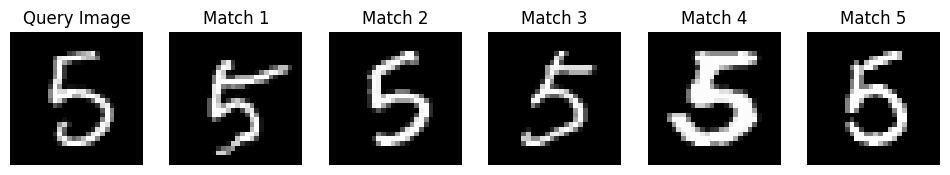

In [103]:
def search_similar_images(query_idx=0, k=5):
    query_feature = test_features[query_idx].to(device)

    with torch.no_grad():

      predicted_bucket = tuple(torch.sign(mlp(query_feature)).long().cpu().numpy().tolist())

    print(f"Hash Bucket : {predicted_bucket}")

    distances, indices = faiss_indices[predicted_bucket].search(query_feature.cpu().float().reshape(1,-1), k)

    vectors = np.array(train_dic[predicted_bucket])

    similar_vectors = vectors[indices].squeeze(0)

    print(f"Retrieved Indices : {indices.squeeze(0)}") 
    
    indices = []

    for query in similar_vectors:
        matches = torch.all(train_features.cpu() == query, dim=1)  
        found_indices = torch.nonzero(matches, as_tuple=True)[0] 
        indices.append(found_indices.item())
    
    

    fig, axes = plt.subplots(1, k+1, figsize=(12, 3))
    axes[0].imshow(test_dataset[query_idx][0].squeeze(), cmap="gray")
    axes[0].set_title("Query Image")
    axes[0].axis(False)

    for i, idx in enumerate(indices[:5]):
        axes[i+1].imshow(train_dataset[idx][0].squeeze(), cmap="gray")
        axes[i+1].set_title(f"Match {i+1}")
        axes[i+1].axis(False)
    plt.show()



search_similar_images(7612)

100%|██████████| 313/313 [00:07<00:00, 41.49it/s]


Digit 0: Precision = 0.990, Recall = 0.998, F1-score = 0.994
Digit 1: Precision = 0.991, Recall = 1.000, F1-score = 0.996
Digit 2: Precision = 0.985, Recall = 0.993, F1-score = 0.989
Digit 3: Precision = 0.992, Recall = 0.993, F1-score = 0.993
Digit 4: Precision = 0.990, Recall = 0.990, F1-score = 0.990
Digit 5: Precision = 0.997, Recall = 0.984, F1-score = 0.990
Digit 6: Precision = 0.993, Recall = 0.985, F1-score = 0.989
Digit 7: Precision = 0.998, Recall = 0.981, F1-score = 0.989
Digit 8: Precision = 0.991, Recall = 0.997, F1-score = 0.994
Digit 9: Precision = 0.990, Recall = 0.992, F1-score = 0.991


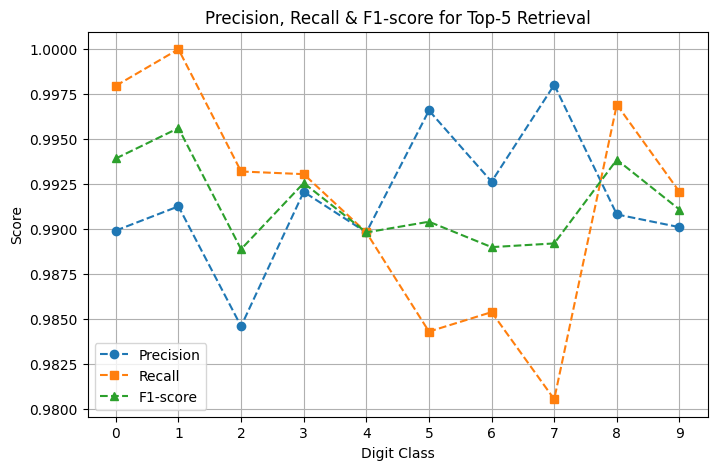

In [279]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import torch
import faiss
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

def compute_precision_recall_batch(k=5, batch_size=100):
    embeddings_dict = {
        bucket: faiss.rev_swig_ptr(index.get_xb(), index.ntotal * index.d).reshape(index.ntotal, index.d)
        for bucket, index in faiss_indices.items()
    }
    
    train_features_np = train_features.cpu().numpy()
    train_features_dict = {
        tuple(feat): idx for idx, feat in enumerate(train_features_np)
    }
    
    y_true = np.zeros(len(test_features), dtype=np.int64)
    y_pred = np.zeros(len(test_features), dtype=np.int64)
    
    batch_size = 32
    num_batches = (len(test_features) + batch_size - 1) // batch_size
    
    with torch.no_grad():  
        for batch_idx in tqdm(range(num_batches)):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, len(test_features))
            
            query_features = test_features[start_idx:end_idx]
            
            predicted_buckets = torch.sign(mlp(query_features.to(device))).long().cpu()
            
            for i, (query_feature, pred_bucket) in enumerate(zip(query_features, predicted_buckets)):
                current_idx = start_idx + i
                query_feature_np = query_feature.numpy().reshape(1, -1)
                bucket_key = tuple(pred_bucket.numpy().tolist())
                
                if bucket_key not in faiss_indices.keys():
                    continue
                distances, indices = faiss_indices[bucket_key].search(query_feature_np, k)
                embeddings = embeddings_dict[bucket_key]
                
                retrieved_features = embeddings[indices[0]]
                retrieved_indices = [train_features_dict[tuple(feat)] for feat in retrieved_features]
                retrieved_labels = train_labels[retrieved_indices]
                
                y_true[current_idx] = test_labels[current_idx].cpu()
                y_pred[current_idx] = Counter(retrieved_labels.tolist()).most_common(1)[0][0]

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

    for digit in range(10):
        print(f"Digit {digit}: Precision = {precision[digit]:.3f}, Recall = {recall[digit]:.3f}, F1-score = {f1[digit]:.3f}")

    plt.figure(figsize=(8, 5))
    x = range(10)
    plt.plot(x, precision, label="Precision", marker="o", linestyle="dashed")
    plt.plot(x, recall, label="Recall", marker="s", linestyle="dashed")
    plt.plot(x, f1, label="F1-score", marker="^", linestyle="dashed")
    plt.xticks(x)
    plt.xlabel("Digit Class")
    plt.ylabel("Score")
    plt.title(f"Precision, Recall & F1-score for Top-{k} Retrieval")
    plt.legend()
    plt.grid()
    plt.show()

compute_precision_recall_batch(k=5, batch_size=512)
